In [ ]:
cd '.\Dropbox\My PC (DESKTOP-M302P50)\Documents\UVic Civil Engineering\PHREEQC\PHREEQC data processing\'
cd '.\Dropbox\My PC (DESKTOP-M302P50)\Documents\UVic Civil Engineering\PHREEQC\PHREEQC\'

The singular script for creating, executing, and processing PHREEQC simulations will be composed. The script will utilize the batch reactor of PHREEQC, in lieu of the interactive software of PHREEQC. The script and the associated GUI will be packaged within an executable file for user accessability.

# core.py

In [ ]:
# import libraries
from matplotlib import pyplot 
from to_precision import auto_notation
from scipy.constants import nano, kilo, milli, centi, liter, day, hour
from itertools import chain
from chempy.properties.water_density_tanaka_2001 import water_density
import phreeqpy.iphreeqc.phreeqc_com as phreeqc_mod
from pubchempy import get_compounds 
from chemicals import periodic_table
import subprocess
import datetime
import pandas
from math import pi, exp, ceil
from glob import glob
import time
import json
import os
import re

# calculation constants
simulated_time_over_computational_time = 9.29    


class ROSSPkg():
    def __init__(self):       
        # establish the general organization structures
        self.parameters = {}
        self.variables = {}
        self.results = {}
        self.results['figures'] = {}

        
    def define_general(self, operating_system, phreeqc_path, database_selection, simulation_type, simulation_title):
        '''Establish general conditions'''
        self.parameters['water_mw'] = float(get_compounds('water', 'name')[0].molecular_weight)
        self.parameters['water_grams_per_liter'] = water_density()
        
        # parameterize the input file
        self.parameters['os'] =  operating_system
        self.parameters['phreeqc_path'] = phreeqc_path
        self.parameters['simulation_type'] = simulation_type
        database_path = f'{__file__}databases/{database_selection}.json'
        
        title_line = 'TITLE\t %s' %(simulation_title)
        if operating_system == 'Windows':
            database_line = 'DATABASE %s' %(database_path)
            self.results['general_conditions'] = [database_line, title_line]
        else:
            self.results['general_conditions'] = [title_line]
            
        # establish the database content
        self.parameters['database_selection'] = database_selection 
        database = json.load(open(database_path, 'r'))
        self.elements = database['elements']
        self.minerals = database['minerals']

    def transport(self, simulation_time, module_characteristics = {}, quantity_of_modules = 1, cells_per_module = 12, domain = 'dual', output_perspective = 'scaling', parameterized_timestep = None, kinematic_flow_velocity = None):
        '''Define the TRANSPORT block'''
        # assign default RO module dimensions 
        self.parameters['module_diameter_mm'] =  201                 
        self.parameters['permeate_tube_diameter_mm'] =  29            
        self.parameters['module_length_m'] =  1.016                 
        self.parameters['permeate_flow_m3_per_day'] = 40                  
        self.parameters['max_feed_flow_m3_per_hour'] = 15.9                  
        self.parameters['membrane_thickness_mm'] = 250 * (nano / milli)   
        self.parameters['feed_thickness_mm'] = 0.8636
        self.parameters['active_m2'] = 37
        self.parameters['permeate_thickness_mm'] = 0.3               
        self.parameters['polysulfonic_layer_thickness_mm'] = 0.05     
        self.parameters['support_layer_thickness_mm'] = 0.15           

        # assign parameterized module dimensions
        for parameter in module_characteristics:
            self.parameters[parameter] = module_characteristics[parameter]
#             self.parameters['module_diameter_mm'] = module_characteristics['diameter']                          
#             self.parameters['permeate_tube_diameter_mm'] = module_characteristics['permeate_diameter']        
#             self.parameters['module_length_m'] = module_characteristics['length']                               
#             self.parameters['permeate_flow_m3_per_day'] = module_characteristics['permeate_flow']                       
#             self.parameters['max_feed_flow_m3_per_hour'] = module_characteristics['feed_flow']                         
#             self.parameters['membrane_thickness_mm'] = module_characteristics['membrane_thickness']              
#             self.parameters['feed_thickness_mm'] = module_characteristics['feed_spacer_thickness']
#             self.parameters['active_m2'] = module_characteristics['active_m2']
#             self.parameters['permeate_thickness_mm'] = input('- What is the permeate spacer thickness? (mm) __ ')
#             self.parameters['polysulfonic_layer_thickness_mm'] = module_characteristics['polysulfonic_thickness']
#             self.parameters['support_layer_thickness_mm'] = module_characteristics['support_thickness']
            
        self.parameters['repeated_membrane_winding_mm'] = 2 * self.parameters['membrane_thickness_mm'] + self.parameters['feed_thickness_mm'] + self.parameters['permeate_thickness_mm'] + 2 * self.parameters['polysulfonic_layer_thickness_mm'] + 2 * self.parameters['support_layer_thickness_mm']     
        print('\nMembrane thickness:', '%s (mm)' %(self.parameters['repeated_membrane_winding_mm']))

        self.parameters['quantity_of_modules'] = quantity_of_modules
        self.parameters['cells_per_module'] = cells_per_module
        self.variables['cell_meters'] = self.parameters['module_length_m'] / self.parameters['cells_per_module']    
        
        # estimate the feed area       
        self.parameters['active_m2_cell'] = self.parameters['active_m2'] / self.parameters['cells_per_module']

        # calculate module properties
        module_cross_sectional_area = self.parameters['module_diameter_mm']**2 * pi / 4        #squared millimeters
        permeate_tube_cross_sectional_area = self.parameters['permeate_tube_diameter_mm']**2 * pi / 4     #squared millimeters
        filtration_cross_sectional_area = module_cross_sectional_area - permeate_tube_cross_sectional_area        #squared millimeters
        feed_cross_sectional_area = (self.parameters['feed_thickness_mm'] / self.parameters['repeated_membrane_winding_mm']) * filtration_cross_sectional_area     #squared millimeters
        self.variables['feed_cubic_meters'] = feed_cross_sectional_area * self.parameters['module_length_m'] * milli**2   
        self.variables['feed_kg'] = self.variables['feed_cubic_meters'] / liter * self.parameters['water_grams_per_liter'] * milli    
        self.variables['feed_moles'] = self.variables['feed_kg'] * kilo / self.parameters['water_mw'] 

        # calculate fluid flow characteristics
        if not kinematic_flow_velocity:
            kinematic_flow_velocity = 9.33E-7    #square meters / second
        feed_velocity = self.parameters['max_feed_flow_m3_per_hour'] / (feed_cross_sectional_area * milli**2) / hour     #meters / second
        reynolds_number = feed_velocity * (self.parameters['module_diameter_mm'] - self.parameters['permeate_tube_diameter_mm']) * milli**2 / kinematic_flow_velocity
        self.variables['Reynold\'s number'] = reynolds_number

        # calculate module cell characteristics
        self.variables['feed_kg_cell'] = self.variables['feed_kg'] / self.parameters['cells_per_module']   
        self.variables['feed_moles_cell'] = self.variables['feed_moles'] / self.parameters['cells_per_module']   

        # calculate simulation timestep that adheres to the Courant condition   
        timestep = self.parameters['module_length_m'] / feed_velocity  # seconds
        if parameterized_timestep:
            timestep = parameterized_timestep
            
        courant_timestep = self.variables['cell_meters'] / feed_velocity
        if timestep < courant_timestep:
            timestep = courant_timestep
            
        # print simulation parameters
        print('cell length (m): ', self.variables['cell_meters'])
        print('feed velocity (m/s): ', feed_velocity) 
        print('feed_cross_sectional_area (mm^2): ', feed_cross_sectional_area)

            
        self.parameters['permeate_moles_per_cell'] = (self.parameters['permeate_flow_m3_per_day'] / day / liter * self.parameters['water_grams_per_liter'] / self.parameters['water_mw']) * (timestep / self.parameters['cells_per_module'])      #moles / (cell * timestep)
        print('permeate_removal_per_cell', self.parameters['permeate_moles_per_cell'])

        # define the transport black
        transport_line = '\nTRANSPORT'
        cells_line = '-cells\t\t\t%s' %(self.parameters['cells_per_module'])
        
        self.simulation_shifts = ceil(simulation_time / timestep) #(self.parameters['cells_per_module']*self.parameters['quantity_of_modules'])
        shifts_line = '-shifts\t\t\t%s' %(self.simulation_shifts)
        lengths_line = '-lengths\t\t%s' %(self.variables['cell_meters'])
        timestep_line = '-time_step\t\t%s\t# the Courant condition is satisfied with the cell_length of %s m and the feed velocity of %s m/s' %(timestep, self.variables['cell_meters'], feed_velocity)
        initial_time_line = '-initial_time\t\t0'    
        boundary_conditions_line = '-boundary_conditions\tconstant\tconstant \t # Dirichlet boundary condition'
        
        if domain == 'single':
            domain_line = '-stagnant\t\t0\t\t0\t\t\t0\t\t0 \t # single domain\n#\t\t\t^stagnant cells\t^exchange factor\t^CP volume\t^bulk volume'
        elif domain == 'dual':
            domain_line = '-stagnant\t\t1\t\t1\t\t\t0.1\t\t0.9 \t # dual domain\n#\t\t\t^stagnant cells\t^exchange factor\t^CP volume\t^bulk volume'

        self.parameters['output_perspective'] = output_perspective
        if self.parameters['output_perspective'] == 'scaling':
            punch_cells_line = '-punch_cells\t\t1-%s' %(self.parameters['cells_per_module'])
            punch_frequency_line = '-punch_frequency\t%s' %(self.simulation_shifts)
        elif self.parameters['output_perspective'] == 'brine':
            punch_cells_line = '-punch_cells\t\t%s' %(self.parameters['cells_per_module'])
            punch_frequency_line = '-punch_frequency\t1'       

        # create the transport block
        self.results['transport_block'] = []
        self.results['transport_block'].extend((transport_line, cells_line, shifts_line, lengths_line, timestep_line, initial_time_line, boundary_conditions_line, domain_line, punch_cells_line, punch_frequency_line))


    def reaction(self, permeate_approach = 'linear_permeate', permeate_efficiency = 1, head_loss = -0.15, final_cf = 2):
        '''Define the REACTION block'''
        self.parameters['permeate_approach'] = permeate_approach
        cfs = []
        cell_moles = []
        reaction_parameters = []
        iteration = 0
        cumulative_cf = 1 
        self.results['reaction_block'] = []
        for module in range(self.parameters['quantity_of_modules']):
            module_previous_moles_removed = 0
            if permeate_approach == 'linear_permeate':
                if iteration == 0:
                    moles = self.variables['feed_moles']

                initial_moles_removed = self.parameters['permeate_moles_per_cell'] * 2 / (1 + exp(head_loss))
                final_moles_removed = initial_moles_removed * exp(head_loss)
                try:
                    removed_moles_slope = ((final_moles_removed - initial_moles_removed) / (self.parameters['cells_per_module'])) / permeate_efficiency
                except:
                    removed_moles_slope = 0
                average_moles_removed = (final_moles_removed + initial_moles_removed) / 2
                print('(Removed moles / cell) slope: ', removed_moles_slope)

                for cell in range(self.parameters['cells_per_module']):
                    removed_moles_in_cell = (cell * removed_moles_slope + initial_moles_removed)
                    reaction_parameters.append(removed_moles_in_cell)
                    module_previous_moles_removed += removed_moles_in_cell
                    
                cf = moles / (moles - module_previous_moles_removed)
                cumulative_cf *= cf

                moles -= module_previous_moles_removed
                iteration += 1
                print('moles', moles)
                print('module_previous_moles_removed', module_previous_moles_removed)

            if permeate_approach == 'linear_cf':
                module_iteration = 0
                initial_cf = 1

                cf_slope = (final_cf - initial_cf) / self.parameters['cells_per_module']
                for cell in range(self.parameters['cells_per_module']):
                    cell_cf = (cell+1) * cf_slope + initial_cf
                    cfs.append(cell_cf)    

                for cf in cfs:
                    moles_to_be_removed =  self.parameters['feed_moles_cell'] - (self.parameters['feed_moles_cell'] / cf)
                    if module_iteration == 0:
                        moles = self.variables['feed_moles']
                        reaction_parameters.append(moles_to_be_removed)
                    if module_iteration > 0:
                        module_previous_moles_removed += reaction_parameters[-1] 
                        reaction_parameter = moles_to_be_removed - module_previous_moles_removed
                        reaction_parameters.append(reaction_parameter)
                        moles -= moles_to_be_removed

                    module_iteration += 1

                cf = cfs[-1]
                cumulative_cf *= cf
                moles = self.parameters['feed_moles'] - moles_to_be_removed   # moles_to_be_removed = the final quantity of moles is calculated with naming from the linear permeate flux method to be consistent  

            if self.parameters['simulation_type'] == 'transport':
                self.results['reaction_block'].append('\n')
                for cell in range(self.parameters['cells_per_module']):
                    cell_number = (cell) + self.parameters['cells_per_module'] * module
                    reaction_line = 'REACTION %s' %(cell_number)
                    
                    if (cell+1) < self.parameters['cells_per_module']:
                        reaction_line += f'\n\tH2O -1; {reaction_parameters[cell_number]}' 
                    elif (cell+1) == self.parameters['cells_per_module']:
                        reaction_line += f'''\n\tH2O -1; {reaction_parameters[cell_number]}
        INCREMENTAL_REACTIONS \ttrue'''     

                    self.results['reaction_block'].append(reaction_line)

            elif self.parameters['simulation_type'] == 'evaporation':
                parameter_quantity = 15                          
                recursive_assymtote_multiplier = 1.335449219     # ??? arbitrary assignment of kg of water in the simulation?
                total_moles_removed = sum(reaction_parameters)
                initial_evaporation_parameter = total_moles_removed / recursive_assymptote_multiplier
                evaporation_reaction_parameters = ['0', initial_evaporation_parameter]  # ???
                for parameter in range(1, parameter_quantity):
                    evaporation_reaction_parameter = evaporation_reaction_parameters[parameter] * 1/4
                    evaporation_reaction_parameters.append(evaporation_reaction_parameter)

                # define the reaction block
                reaction_line = 'REACTION 1'
                reaction_line += '\n\tH2O -1; '
                reaction_line += ' '.join(evaporation_reaction_parameters) 
                self.parameters['reaction_block'] = [reaction_line]

            # the calculated reaction parameters will be added and printed to a generated PHREEQC input file
            final_solution_mass = moles * self.parameters['water_mw'] * milli  #kg water mass
            final_cf_cell = self.variables['feed_kg'] / final_solution_mass

            if self.parameters['os'] == 'windows':
                self.results['reaction_block'].append('#%s' %(permeate_approach))
                if permeate_approach == 'linear permeate':
                    self.results['reaction_block'].append('''
        #Permeate efficiency parameter: %s
        #Head loss parameter: %s''' %(permeate_efficiency, head_loss))
                self.results['reaction_block'].append('''    #Effluent module %s:
        #Estimated CF: %s
        #Estimated solution mass: %s\n\n''' %(module + 1, cumulative_cf, final_solution_mass))
                
        if self.verbose:
            print('Effluent module %s CF:' %(module + 1), final_cf_cell)


    def solutions(self, water_selection, custom_water_parameters = {}, solution_description = '', parameterized_alkalinity = False, parameterized_ph_charge = True):
        """Specify the SOLUTION block of the simulation."""
        # create the solution line of the input file
        self.results['solution_block'] = []
        
        self.parameters['water_selection'] = water_selection

        if self.parameters['simulation_type'] == 'transport':
            initial_solution_line = '\nSOLUTION 0\t%s' % (solution_description)
        elif self.parameters['simulation_type'] == 'evaporation':
            initial_solution_line = '\nSOLUTION 1\t%s' % (solution_description)
        self.results['solution_block'].append(initial_solution_line)

        #=============================================================================
        # determine which predefined solution should be simulated

        if water_selection is not None:       
            # import the predefined water body
            water_file_path = f'./water_bodies/{water_selection}.json'
            water_body = json.load(open(water_file_path))
            
            elements_lines = []
            for content, information in water_body.items():
                if content == 'element':
                    for element, information2 in information.items():
                        if element in self.elements:
                            conc = information2['concentration (ppm)']
                            ref = information2['reference']
                            if len(str(conc)) <= 3:
                                elements_lines.append(f'{element}\t\t{conc}\t#{ref}')
                            else:
                                elements_lines.append(f'{element}\t{conc}\t#{ref}')
                        else:
                            print('\n--> ERROR: The {} element is not accepted by the {} database')
                                
                elif content == 'temperature':
                    temperature = information['celcius']
                    temperature_reference = information['reference']
                elif content == 'pe':
                    pe = information['value']
                    pe_reference = information['reference']
                elif content == 'Alkalinity':
                    alkalinity = information['value']
                    alkalinity_reference = information['reference'] 
                elif content == 'pH':
                    ph = information['value']
                    ph_reference = information['reference']

        if custom_water_parameters != {}:
            for content, information in custom_water_parameters.items():
                
                if content == 'element':
                    for element, information2 in information.items():
                        conc = information2['concentration (ppm)']
                        ref = information2['reference']
                        if element in self.elements:                          
                            if len(str(conc)) <= 3:
                                elements_lines[element] = (f'{element}\t\t{conc}\t#{ref}')
                            else:
                                elements_lines[element] = (f'{element}\t{conc}\t#{ref}')
                        else:
                            print('\n--> ERROR: The {} element is not accepted by the {} database'.format(element, self.parameters['database_selection']))
                                    
                            
                # create the temperature line of the input file
                elif content == 'temperature':                    
                    temperature = custom_water_parameters['temperature']['value']
                    temperature_reference = custom_water_parameters['temperature']['reference']

                elif content == 'pe':       
                    pe = custom_water_parameters['pe']['value']
                    pe_reference = custom_water_parameters['pe']['reference']

                elif content == 'Alkalinity':
                    alkalinity = custom_water_parameters['Alkalinity']['value']
                    alkalinity_reference = custom_water_parameters['Alkalinity']['reference'] 

                elif content == 'pH':
                    ph = custom_water_parameters['ph']['value']
                    ph_reference = custom_water_parameters['ph']['reference']
                    
                    
        # parameterize the lines of the SOLUTIONS block
        temperature_line = f'temp \t {temperature} \t #{temperature_reference}.'

        if parameterized_ph_charge and not parameterized_alkalinity:
            ph_line = f'pH \t\t {ph} charge #{ph_reference}'
            alkalinity_line = ''
        elif parameterized_alkalinity and not parameterized_ph_charge:
            ph_line = f'pH \t\t {ph} #{ph_reference}'
            alkalinity_line = f'Alkalinity \t {alkalinity} #{alkalinity_reference}'
        else:
            print('ERROR: The pH charge balance cannot execute when the alkalinity is defined.')
            
        pe_line = f'pe \t\t {pe} \t   #{pe_reference} // 4.00 is the default (?)'            
        unit_line = 'units \t ppm' 
        elements_line = '\n'.join(elements_lines)
        water_mass = self.variables['feed_kg']
        if water_selection == 'Bakken formation':
            water_line = f'-water \t{water_mass}\t#TDS=300 ppthousand [before fudging]' 
        elif water_selection == 'German Basin':
            water_line = f'-water \t{water_mass}\t#TDS=314 ppthousand [before fudging]'
        else:
            water_line = f'-water \t{water_mass}'

        self.results['solution_block'].extend([temperature_line, ph_line, pe_line, alkalinity_line, unit_line, elements_line, water_line])

        #parameterize the initial module solution
        if self.parameters['simulation_type'] == 'transport':
            total_cells = self.parameters['cells_per_module'] * self.parameters['quantity_of_modules']
            feed_solution_line = f'\nSOLUTION 1-{total_cells}\tInitial solution in the RO module'
            self.results['solution_block'].extend([feed_solution_line,'temp \t 25','units \t ppm'])

            for element in self.elements:
                element_concentration = 0
                element_line = f'{element}\t{element_concentration}'    
                self.results['solution_block'].append(element_line)

            water_line = '-water \t %s' %(water_mass)
            self.results['solution_block'].append(water_line)


    def equilibrium_phases(self, block_comment = '', ignored_minerals = [], existing_parameters = {}, verbose = True):
        """Specify the EQUILIBRIUM_PHASES block of the simulation."""
        # define mineral sizes for later spacing
        short_mineral_names = ['Barite', 'Gypsum','Halite', 'Natron', 'Quartz', 'Talc','Trona', 'Borax', 'Albite', 'K-mica','Illite', 'Pyrite', 'Sulfur',]
        long_mineral_names = ['Anthophyllite', 'Hexahydrite', 'Leonhardite', 'Nesquehonite', 'Pentahydrite', 'Portlandite','Sepiolite(d)', 'Boric_acid,s', 'K2B4O7:4H2O', 'NaB5O8:5H2O', 'Rhodochrosite', 'Strontianite','Hydroxyapatite', 'Chlorite(14A)', 'Mackinawite', 'Hausmannite', 'Pyrochroite']
        
        # determine the set of possible minerals 
        elements_list = list(self.elements)
        compounds_list = [self.elements[x]['gfw_formula'] for x in elements_list]
        total_accepted_characters = list(chain(compounds_list, elements_list))

        self.variables['described_minerals'] = {}
        for mineral in self.minerals:
            mineral_formula = self.minerals[mineral]['formula']
            original_formula = mineral_formula
            
            # remove entities is an ordered fashion
            mineral_formula = re.sub('(SO4|H2O|OH|CO3)', '', mineral_formula)
            mineral_formula = re.sub('([0-9()•:.])', '', mineral_formula)
            mineral_elements = re.findall('[A-Z][a-z]?', mineral_formula)
            
            for element in mineral_elements:
                if element in elements_list:
                    mineral_formula = re.sub(element, '', mineral_formula)
            if mineral_formula == '':
                self.variables['described_minerals'][mineral] = {'formula': original_formula}
            else:
                if verbose:
                    print(f'--> < {mineral_formula} > characters of < {mineral} >, formula = < {original_formula} > , are undescribed by the parameterized elements.')
                        
        # define the equilibrium_phases block
        self.results['equilibrium_phases_block'] = []
        if self.parameters['simulation_type'] == 'transport':
            equilibrium_phases_number = '1-{}'.format(self.simulation_shifts)
        elif self.parameters['simulation_type'] == 'evaporation':
            equilibrium_phases_number = '1'
            
        equilibrium_phases_line = f'\nEQUILIBRIUM_PHASES {equilibrium_phases_number}\t{block_comment}'
        self.results['equilibrium_phases_block'].append(equilibrium_phases_line)

        # define the equilibrium_phases lines for the code block
        for possible_mineral in self.variables['described_minerals']:
            if possible_mineral not in ignored_minerals:
                if possible_mineral in short_mineral_names:
                    mineral_line = f'{possible_mineral}\t\t' 
                elif possible_mineral == 'Ca-Montmorillonite':
                    mineral_line = f'{possible_mineral}'
                else:
                    mineral_line = f'{possible_mineral}\t'

                if possible_mineral in existing_parameters:
                    for key, value in existing_parameters[possible_mineral].items():
                        if key == 'saturation':
                            mineral_saturation = value['saturation']
                            mineral_line += f'\t{mineral_saturation}'
                        if key == 'initial_moles':
                            initial_moles = value['initial_moles']
                            mineral_line += f'\t{initial_moles}'
                else:
                    mineral_line += f'\t0\t0'
                    
                self.results['equilibrium_phases_block'].append(mineral_line)        

    def selected_output(self, output_filename = None):
        '''Specify the output file after a PHREEQC simulation'''
        # create parameter lines 
        if output_filename is None:
            count = 0
            selected_output_file_name = '_'.join([str(x) for x in [datetime.date.today(), self.parameters['water_selection'], self.parameters['simulation_type'], self.parameters['database_selection'], self.parameters['output_perspective'], count]]) 
            while os.path.exists(f'{selected_output_file_name}.txt'):
                count += 1
                selected_output_file_name = '_'.join([str(x) for x in [datetime.date.today(), self.parameters['water_selection'], self.parameters['simulation_type'], self.parameters['database_selection'], self.parameters['output_perspective'], count]]) 
        else:
            selected_output_file_name = output_filename

        selected_output_file_name += '.txt'
        self.parameters['selected_output_file_name'] = selected_output_file_name

        minerals_line = ''
        for mineral in self.minerals:
             minerals_line += f' {mineral}'

        elements_line = ''
        for element in self.elements:
             elements_line += f' {element}'

        # define parameter lines
        first_line = '\nSELECTED_OUTPUT'
        file_name_line = f'-file\t\t\t{selected_output_file_name}'
        reaction_line = '-reaction\t\ttrue'
        temperature_line = '-temperature\t\ttrue'
        total_elements_line = '-totals\t\t\t' + elements_line    
        saturation_indices_line = f'-saturation_indices\t{minerals_line}'
        equilibrium_phases_line = f'-equilibrium_phases\t{minerals_line}'
        ph_line = '-pH\t\t\ttrue'
        solution_line = '-solution'
        time_line = '-time\t\t\ttrue'
        distance_line = '-distance\t\ttrue'
        simulation_line = '-simulation\t\ttrue'
        high_precision_line = '-high_precision\ttrue'
        step_line = '-step'
        water_line = '-water'

        # establish the selected_output_block
        self.results['selected_output_block'] = []
        self.results['selected_output_block'].extend((first_line, file_name_line, reaction_line, temperature_line, total_elements_line, saturation_indices_line, equilibrium_phases_line, ph_line, time_line, distance_line, simulation_line, high_precision_line, solution_line, step_line,water_line))


    def export(self, input_path = None, output_path = None, print_block = True):
        """View and export the PHREEQC input file"""
        # define the simulation input path 
        if input_path is None:
            file_number = 0
            if self.parameters['permeate_approach'] == 'linear_permeate':
                permeate_approach_name = 'LinPerm'
            elif self.parameters['permeate_approach'] == 'linear_cf':
                permeate_approach_name = 'LinCF'

            simulation_name = '_'.join([str(x) for x in [datetime.date.today(), 'ROSS', self.parameters['water_selection'], self.parameters['simulation_type'], self.parameters['database_selection'],self.parameters['output_perspective'], permeate_approach_name, file_number]])
            while os.path.exists(simulation_name):
                file_number += 1
                simulation_name = '_'.join([str(x) for x in [datetime.date.today(), 'ROSS', self.parameters['water_selection'], self.parameters['simulation_type'], self.parameters['database_selection'],self.parameters['output_perspective'], permeate_approach_name, file_number]])

            self.parameters['input_file_name'] = 'input.pqi'
            working_directory = os.getcwd()
            self.simulation_path = os.path.join(working_directory, simulation_name)
            os.mkdir(self.simulation_path)
            self.parameters['input_path'] = os.path.join(self.simulation_path, self.parameters['input_file_name'])

        else:
            self.parameters['input_path'] = input_path
            
        # comment the corresponding simulation in the input file
        simulation_line = '# {}'.format(self.simulation_path)
        self.results['solution_block'].insert(0, simulation_line)
        
        self.results['complete_lines'] = chain(self.results['general_conditions'], self.results['solution_block'], self.results['equilibrium_phases_block'], self.results['reaction_block'], self.results['selected_output_block'], self.results['transport_block']) 
            
        # printing and exporting the input file
        with open(self.parameters['input_path'],'w') as input_file:
            for line in self.results['complete_lines']:
                if print_block:
                    print(line)
                input_file.write(line + '\n')
            
        self.input_file = open(self.parameters['input_path'],'r').read()
        
        # define the simulation output path 
        if output_path is None:
            self.parameters['output_file_name'] = 'output.pqo'
            self.parameters['output_path'] = os.path.join(self.simulation_path, self.parameters['output_file_name'])
        else:
            self.parameters['output_path'] = output_path    
            
        
        # define a table of parameters
        parameters = {'parameter':[], 'value':[]}
        parameters['parameter'].append('simulation')
        parameters['value'].append(self.simulation_path)
        for parameter in self.parameters:
            parameters['parameter'].append(parameter)
            parameters['value'].append(self.parameters[parameter])
        parameters_table = pandas.DataFrame(parameters)
        display(parameters_table)
        
        parameters_file_name = 'parameters.csv'
        parameters_path = os.path.join(self.simulation_path, parameters_file_name)
        parameters_table.to_csv(parameters_path)
        
        # define a table of variables
        variables = {'variable':[], 'value':[]}
        variables['variable'].append('simulation')
        variables['value'].append(self.simulation_path)
        for variable in self.variables:
            variables['variable'].append(variable)
            variables['value'].append(self.variables[variable])
        variables_table = pandas.DataFrame(variables)
        display(variables_table)
        
        variables_file_name = 'variables.csv'
        variables_path = os.path.join(self.simulation_path, variables_file_name)
        variables_table.to_csv(variables_path)

    def execute(self, print_output = True):
        '''Execute a PHREEQC input file '''
        self.parameters['database_path'] = os.path.join(self.parameters['phreeqc_path'], 'database\\{}.dat'.format(self.parameters['database_selection']))

        def run(input_file, first=False):
            phreeqc = phreeqc_mod.IPhreeqc()                 
            phreeqc.load_database(self.parameters['database_path'])
            phreeqc.run_string(input_file)
            
            # define the conc dictionary
            output = phreeqc.get_selected_output_array()

            header = output[0]
            conc = {}
            for head in header:
                conc[head] = []
            for row in output[1:]:
                for col, head in enumerate(header):
                    conc[head].append(row[col])
                    
            return phreeqc, conc

        def main(input_file, print_output):
            import timeit

            def measure_time(func, *args, **kwargs):
                start = timeit.default_timer()
                phreeqc, conc = func(*args, **kwargs)
                return phreeqc, conc, timeit.default_timer() - start

            phreeqc, conc, run_time = measure_time(run, input_file, print_output)
            
            # export the simulation results
            fobj = open(self.parameters['output_path'], 'w')
            headers = conc.keys()
            if print_output:
                pandas.set_option('display.max_columns', None)
                self.results['csv_data'] = pandas.DataFrame(conc, columns = headers)
                display(self.results['csv_data'])
            fobj.write(self.results['csv_data'].to_string())
            
            self.variables['run_time (s)'] = run_time

        # verify that the PHREEQC executed and generated the appropriate files
        main(self.input_file, print_output)
        
        if os.path.exists(self.parameters['output_path']):
            self.parameters['selected_output_path'] = os.path.join(self.simulation_path, self.parameters['selected_output_file_name'])
            if os.path.exists(self.parameters['selected_output_path']):
                print('The execution is complete.')
            else:
                print('ERROR: The SELECTED_OUTPUT file {} is missing. The simulation failed to simulate.'.format(self.parameters['selected_output_file_name']))
        else:
            print('\nERROR: The simulation failed to execute.')
            

    def process_selected_output(self, selected_output_path = None, graphical_selection = 'scaling', plot_title = '', title_font = 'xx-large', label_font = 'x-large', plot_caption = '', table_title = None, export_figure = True, export_format = 'svg', individual_plots = True):
        """Interpreting the PHREEQC SELECTED_OUTPUT file and conducting the plotting functions"""
        self.parameters['graphical_selection'] = graphical_selection
        
        databases = [database for database in glob('./databases/*.json')]
        databases = [re.search('(\w+)(?=.json)', database).group() for database in databases]

        if 'csv_data' not in self.results:
            # determining the appropriate variables
            if selected_output_path is not None:
                # define the simulation perspective
                self.parameters['output_perspective'] = 'scaling'
                if re.search('(brine)', selected_output_path, flags=re.IGNORECASE):
                    self.parameters['output_perspective'] = 'brine'

                # define the simulation type
                self.parameters['simulation_type'] = 'transport'
                for line in selected_output_path:
                    if re.search('(evaporation)', line, re.IGNORECASE):
                        self.parameters['simulation_type'] = 'evaporation'

                # define the database contents
                self.parameters['database_selection'] = 'llnl'
                for database in databases:
                    names = database.split('_')
                    if all(re.search(name, selected_output_path, re.IGNORECASE) for name in names):
                        self.parameters['database_selection'] = database                   
                        break                    

                database_json = json.load(open('./databases/{}.json'.format(self.parameters['database_selection'])))
                self.minerals = database_json['minerals']
                self.elements = database_json['elements']

                # define the simulation
                self.parameters['selected_output_file_name'] = re.search('(\w+)(?=\.)', selected_output_path).group()

            else:
                working_directory = os.getcwd()
                selected_output_path = os.path.join(working_directory, self.parameters['selected_output_file_name'])                     

            # preparing the SELECTED_OUTPUT file into a dataframe
            selected_output = open(selected_output_path, 'r')
            original_data = pandas.read_table(selected_output, sep = '\t')
            self.results['csv_data'] = pandas.DataFrame(original_data)
            for column in self.results['csv_data'].columns:
                new_column = column.strip()
                self.results['csv_data'].rename(columns={column:new_column}, inplace = True)

        self.variables['initial_solution_mass'] = self.results['csv_data'].at[0, 'mass_H2O']
        final_solution_mass = self.results['csv_data']['mass_H2O'].iloc[-1]
        self.variables['simulation_cf'] = self.variables['initial_solution_mass'] / final_solution_mass
                                 
        # conducting the appropriate visualization function
        if self.parameters['graphical_selection'] == 'brine':
            pyplot = self.plot_definition(plot_title, title_font, label_font,)
            data = self.brine_plot(pyplot, plot_title, title_font, label_font, plot_caption, table_title, export_figure, export_format)
        elif self.parameters['graphical_selection'] == 'scaling':
            data = self.scaling_plot(plot_title, title_font, label_font, plot_caption, table_title, individual_plots, export_figure, export_format)
        return data
                                 
    def plot_definition(self, plot_title, title_font, label_font):
        pyplot.figure(figsize = (17,10))
        pyplot.title(plot_title, fontsize = title_font)                
        pyplot.grid(True)
                                 
        if (self.parameters['graphical_selection'] or self.parameters['output_perspective']) == 'brine':
            if plot_title == '':
                 plot_title = 'Effluent brine elemental concentrations'
            pyplot.figure(figsize = (17,10))
            pyplot.xlabel('Time (s)', fontsize = label_font)
            pyplot.ylabel('Concentration (ppm)', fontsize = label_font)
            pyplot.yscale('log')
            pyplot.legend(elements, loc='best', title = 'non-zero elements', fontsize = 'x-large')
        else:
            if plot_title == '':
                 plot_title = 'scaling throughout the RO module'
            pyplot.xlabel('Midpoint module distance (m)', fontsize = label_font)
            pyplot.ylabel('Quantity (moles)', fontsize = label_font)  
                                 
        return pyplot
                                 
    def brine_plot(self, pyplot, plot_title, title_font, label_font, plot_caption, table_title, export_figure, export_format):
        """Generate plots of the elemental concentrations from effluent brine in the PHREEQC SELECTED_OUTPUT file  """
        elements = []
        for column in self.results['csv_data'].columns:
            if re.search('([A-Z][a-z]?(\(\d\))?){1}$', column) and not re.search('(_|H2O|pH)', column):
                elements.append(column)

        self.results['csv_data'].drop(self.results['csv_data'].index[:3], inplace=True)

        # plot the brine concentrations figure
        unit = 'mol/kgw'
        concentration_array = []

        for element in elements:  
            concentration_serie = []
            scaling_serie = []
            initial_solution_time = 0
            for index, row in self.results['csv_data'].iterrows():
                if self.results['csv_data'].at[index, 'Cl'] == 0:
                    initial_solution_time += 1
                else:
                    concentration_serie.append(self.results['csv_data'].at[index, element])
                    delta_time = self.results['csv_data'].at[index, 'time'] - self.results['csv_data'].at[index-1, 'time']
                    scaling_serie.append(self.results['csv_data'].at[index, 'time'] - initial_solution_time * delta_time)

            pyplot.plot(scaling_serie,concentration_serie)

        pyplot.figtext(0.2, 0, 'Desalination CF: %s' %(self.variables['simulation_cf']), wrap=True, horizontalalignment='left', fontsize=12)
        figure = pyplot.gcf()
        if plot_caption == '':
            plot_caption = '''\n\nbrine Figure:\n%s 
                    The effluent concentrations of each existing element in the brine. brine plots from brine data rapidly reach a steady state elemental concentration. brine plots from scaling data consist of vertical concentrations that represent the concentrations at each distance throughout the RO module at the specified time, where the low end represents the influent concentration while the high end represents the effluent concentration.''' %('='*len('brine Figure'))
                                 
        print(plot_caption)
        pyplot.show()

        # create a complementary concentration data table
        loop_iteration = 1
        table_view = {}
        average_concentrations_table = pandas.DataFrame()
        index_elements = []
        if self.parameters['output_perspective'] == 'scaling':
            for element in self.elements:
                quantity_of_steps_index = 0
                average_iteration = 0
                scaling_serie = []            
                time_averages = {}
                for index, row in self.results['csv_data'].iterrows():
                    if self.results['csv_data'].at[index, 'time'] == 0:            
                        quantity_of_steps_index += 1                    

                    elif self.results['csv_data'].at[index-1,'soln'] == quantity_of_steps_index:       
                        #process the complete time serie
                        try:
                            average_concentration = sum(scaling_serie) / len(scaling_serie)
                        except:
                            average_concentration = 0

                        #print(average_concentration)
                        table_view['Time (s): %s' %(average_iteration * quantity_of_steps_index)] = average_concentration
                        average_iteration += 1 

                        #begin the new time serie
                        scaling_serie = []
                        time_averages = {}
                        scaling_serie.append(self.results['csv_data'].at[index,element])  

                    elif index == len(self.results['csv_data'][element]) + 2:       
                        scaling_serie.append(self.results['csv_data'].at[index,element])            
                        try:
                            average_concentration = sum(scaling_serie) / len(scaling_serie)
                        except:
                            average_concentration = 0
                        table_view['Time (s): %s' %(round(average_iteration * quantity_of_steps_index), 1)] = average_concentration
                        average_iteration += 1
                        index_elements.append(element)
                        average_concentrations_table = average_concentrations_table.append(table_view, ignore_index=True)
                        loop_iteration += 1

                    else:
                        scaling_serie.append(self.results['csv_data'].at[index,element])

            # defining the index column of the DataFrame
            average_concentrations_table.index = index_elements
            average_concentrations_table.index.name = 'Elements'
            if table_title is None:
                table_title = 'Average elemental molal concentrations of the feed water in the RO module for each %s seconds of simulation:' %(quantity_of_steps_index)

        # create a complementary concentration data table for the brine figure 
        elif self.parameters['output_perspective'] == 'brine':
            total_time = self.results['csv_data']['time'].iloc[-1]
            for element in elements:  
                concentration_serie = []
                scaling_serie = []
                for index, row in self.results['csv_data'].iterrows():
                    if self.results['csv_data'].at[index, 'Cl'] != 0:
                        concentration_serie.append(self.results['csv_data'].at[index,element])      
                average_concentration = sum(concentration_serie) / len(concentration_serie)
                table_view['%s' %(element)] = average_concentration

            average_concentrations_table = average_concentrations_table.append(table_view, ignore_index=True)
            average_concentrations_table.rename(index = {0:'Concentrations (molal)'}, inplace = True)
            if table_title is None:
                table_title = 'Average elemental molal concentrations of the feed water in the RO module over %s seconds of simulation:' %(total_time)

        print('\n\n\n',table_title,'\n%s'%('='*len(table_title)))
        print(average_concentrations_table)

        # export the graphic
        if export_figure:
            self.export_plot(figure, plot_title, export_format)
                                 

    def scaling_plot(self, plot_title, title_font, label_font, plot_caption, table_title, individual_plots, export_figure, export_format = 'svg'):
        """Generate plots of scaling along the module distance in the PHREEQC SELECTED_OUTPUT file  """
        # define reused functions
        def series_creation():
            iteration = 0
            distance_serie = []
            scaling_serie = []
            quantity_of_steps_index = 0   
            time = 0
            for index, row in self.results['csv_data'].iterrows():
                if self.results['csv_data'].at[index, 'time'] == 0:
                    quantity_of_steps_index += 1   

                elif self.results['csv_data'].at[index-1, 'soln'] == quantity_of_steps_index:
                    if time != 0:
                        legend_entry.append(f'{mineral} [{mineral_formula}] ; {auto_notation(time, 3)} sec')
                        pyplot.plot(distance_serie,scaling_serie)
                        
                        distance_serie = []
                        scaling_serie = []
                        grams_area = (float(self.results['csv_data'].at[index, mineral]) * self.minerals[mineral]['mass']) / (self.parameters['active_m2_cell'])
                        scaling_serie.append(auto_notation(grams_area, 3))
                        distance_serie.append(self.results['csv_data'].at[index, 'dist_x'])
                    time = self.results['csv_data'].at[index, 'time']

                elif index == len(self.results['csv_data'][mineral]) + 2:   
                    legend_entry.append(f'{mineral} [{mineral_formula}] ; {auto_notation(time, 3)} sec')
                    pyplot.plot(distance_serie,scaling_serie)

                else:
                    print('mineral', self.minerals[mineral])
                    print('mass', self.minerals[mineral]['mass'])
                    print('active_cm_squared_cell', (self.parameters['active_m2_cell'] / centi**2))
                    grams_area = (float(self.results['csv_data'].at[index, mineral]) * self.minerals[mineral]['mass']) / (self.parameters['active_m2_cell'])
                    scaling_serie.append(grams_area)
                    distance_serie.append(self.results['csv_data'].at[index, 'dist_x'])
                    iteration += 1
                                 
            return legend_entry     
                                 
        def illustrate(pyplot):                     
            pyplot.legend(legend_entry, loc='best', fontsize = 'x-large')
            pyplot.figtext(0.2, 0, 'Final CF: %s' %(self.variables['simulation_cf']), wrap=True, horizontalalignment='left', fontsize=12)
            figure = pyplot.gcf()
            pyplot.show()
                        
            return figure
                                 
        # the complete list of all minerals is created
        csv_minerals = []
        for column in self.results['csv_data'].columns:
            if re.search('([A-Z].{3,})', column) and not re.search('[(_:]', column):
                csv_minerals.append(column)

        if self.parameters['simulation_type'] == 'transport':
            self.results['csv_data'].drop(self.results['csv_data'].index[:3], inplace=True)

        # all of the non-zero minerals are identified and the chemical formulas are sorted into a list
        non_zero_minerals = set()
        for mineral in csv_minerals:
            for value in self.results['csv_data'][mineral]:
                if value != 0:
                    non_zero_minerals.add(mineral)

        quantity_nonzero_minerals = len(non_zero_minerals)    
        
        # define a dictionary of precipitated minerals
        self.variables['precipitated_minerals'] = {}
        for mineral in self.minerals:
            if mineral in non_zero_minerals:
                self.variables['precipitated_minerals'][mineral] = self.minerals[mineral]

        # plot the simulation depending upon the simulation perspective
        unit = 'moles'
        if self.parameters['output_perspective'] == "brine":
            legend_entry = []
            formula_index = 0
            for mineral in non_zero_minerals:
                mineral_formula = self.minerals[mineral]['formula']
                                 
                mineral_serie = []
                scaling_serie = []
                for index, row in self.results['csv_data'].iterrows():
                    mineral_serie.append(self.results['csv_data'].at[index, mineral]) 
                    time = self.results['csv_data'].at[index, 'time']
                    scaling_serie.append(time)

                pyplot.plot(scaling_serie,mineral_serie)
                pyplot.scatter(scaling_serie,mineral_serie)

                legend_entry.append(f'{mineral} [{mineral_formula}]')   

            # export the figure
            figure = illustrate(pyplot)
            if export_figure:
                self.results['figures'][self.parameters['selected_output_file_name']] = {'figure':figure, 'title':plot_title}
                self.export_plot(figure, plot_title, export_format)

        elif self.parameters['output_perspective'] == 'scaling':
            if quantity_nonzero_minerals < 2:
                individual_plots = 'n'
            elif quantity_nonzero_minerals >= 2:
                individual_plots = 'y'
            print(f'\nQuantity of precipitated minerals: {quantity_nonzero_minerals}')

            if individual_plots:
                for mineral in non_zero_minerals:
                    print(mineral)
                    mineral_formula = self.minerals[mineral]['formula']
                                 
                    pyplot.figure(figsize = (17,10))
                    pyplot.title(plot_title, fontsize = title_font)

                    if self.parameters['simulation_type'] == 'transport':
                        pyplot.xlabel('Midpoint module distance (m)', fontsize = label_font)
                        pyplot.ylabel('Quantity (g/m^2)', fontsize = label_font) 
                        legend_entry = []

                        legend_entry = series_creation()
                        

                    elif self.parameters['simulation_type'] == 'evaporation':
                        pyplot.xlabel('Concentration Factor (CF)', fontsize = label_font)
                        pyplot.ylabel('Quantity (%s)' %(unit), fontsize = label_font)  

                        legend_entry = []
                        cf_series = []
                        concentration_series = []
                        data_length = len(self.results['csv_data']['mass_H2O'])
                        for index, row in self.results['csv_data'].iterrows():
                            if index < data_length:
                                if self.results['csv_data'].at[index, 'step'] >= 1:
                                    concentration_series.append(self.results['csv_data'].at[index, mineral]) 
                                    solution_mass = self.results['csv_data'].at[index, 'mass_H2O']
                                    cf_series.append(self.variables['initial_solution_mass'] / solution_mass)  
                                elif index > 1:
                                    print('ERROR: The SELECTED_OUTPUT file possesses an unexcepted data structure.')

                        concentration_series.append(self.results['csv_data'].at[index, mineral]) 
                        solution_mass = self.results['csv_data'].at[index, 'mass_H2O']
                        cf_series.append(self.variables['initial_solution_mass'] / solution_mass)  

                        legend_entry.append(f'{mineral} [{mineral_formula}]')
                        pyplot.plot(cf_series,concentration_series)                    

                    # export the figure
                    figure = illustrate(pyplot)
                    if export_figure:
                        self.export_plot(figure, plot_title, mineral, export_format)


            elif not individual_plots:
                legend_entry = []
                for mineral in non_zero_minerals:
                    if self.parameters['simulation_type'] == 'transport':
                        legend_entry = series_creation()

                    elif self.parameters['simulation_type'] == 'evaporation':
                        pyplot.xlabel('Concentration Factor (CF)', fontsize = label_font)
                        pyplot.ylabel('Quantity (%s)' %(unit), fontsize = label_font)  

                        legend_entry = []
                        iteration = 0
                        cf_series = []
                        concentration_series = []
                        self.variables['initial_solution_mass'] = self.results['csv_data'].at[0, 'mass_H2O']
                        for index, row in self.results['csv_data'].iterrows():
                            try:
                                if self.results['csv_data'].at[index+1, 'mass_H2O']:
                                    if self.results['csv_data'].at[index, 'step'] >= 1:
                                        concentration_series.append(self.results['csv_data'].at[index, mineral]) 
                                        solution_mass = self.results['csv_data'].at[index, 'mass_H2O']
                                        cf_series.append(self.variables['initial_solution_mass'] / solution_mass)   
                                    else:
                                        print('ERROR: The SELECTED_OUTPUT file possesses an unexcepted data structure.')

                            except:
                                concentration_series.append(self.results['csv_data'].at[index, mineral]) 
                                solution_mass = self.results['csv_data'].at[index, 'mass_H2O']
                                cf_series.append(self.variables['initial_solution_mass'] / solution_mass)  

                                legend_entry.append(f'{mineral} [{mineral_formula}]')
                                pyplot.plot(mass_series,concentration_series)

                                cf_series = []
                                concentration_series = []
                                concentration_series.append(self.results['csv_data'].at[index, mineral]) 
                                solution_mass = self.results['csv_data'].at[index, 'mass_H2O']
                                cf_series.append(self.variables['initial_solution_mass'] / solution_mass)         
                                                         
                    # export the figure
                    figure = illustrate(pyplot)
                    self.export_plot(figure, plot_title, export_format)


    def export_plot(self, figure, plot_title, mineral = None, individual_plots = False, export_format = 'svg'):
        """Export the plots to the current working directory  """
        # define the output name
        export_name = mineral
                                                         
        self.results['figures'][export_name] = {'figure':figure, 'title':plot_title}
                                
        # export the plot
        file_number = 0
        figure_path = os.path.join(self.simulation_path, export_name)
        if not os.path.exists('{}.{}'.format(figure_path, export_format)):
            self.results['figures'][export_name]['figure'].savefig('{}.{}'.format(figure_path, export_format))
        elif os.path.exists('{}.{}'.format(figure_path, export_format)):
            while os.path.exists('{}_{}.{}'.format(figure_path, file_number, export_format)):
                file_number += 1
            figure.savefig('{}_{}.{}'.format(figure_path, file_number, export_format))


    def input_file(self, operating_system, phreeqc_path, database_selection, simulation_type, simulation_title, water_selection, quantity_of_modules = 1, module_characteristics = {}, output_perspective = 'scaling', domain = 'dual', permeate_approach = 'linear permeate', permeate_efficiency = 1, head_loss = -0.15, final_cf = 2, custom_water_parameters = {}, ignored_minerals = [], existing_parameters = {}, export_figure = True):
        """Concisely create an input file of the software """
        self.define_general(operating_system, phreeqc_path, database_selection, simulation_type, simulation_title)
        self.transport(module_characteristics = module_characteristics, quantity_of_modules = quantity_of_modules, domain = domain, output_perspective = output_perspective)
        self.reaction(permeate_approach = permeate_approach, permeate_efficiency = permeate_efficiency, head_loss = head_loss, final_cf = final_cf)
        self.solutions(water_selection = water_selection, custom_water_parameters = custom_water_parameters)
        self.equilibrium_phases(ignored_minerals = ignored_minerals, existing_parameters = existing_parameters)
        self.selected_output()
        self.export()
        
            
    def complete_simulation():
        self.execute()
        self.process_selected_output(export_figure = export_figure)

# execute the model

In [ ]:
ross = ROSSPkg()

# initial parameters
operating_system = 'windows'
phreeqc_path = 'C:\\Program Files\\USGS\\phreeqc-3.6.2-15100-x64'
database_selection = 'pitzer'
simulation_type = 'transport'
simulation_title = 'test'
water_selection = 'red_sea'
selected_output_path = 'Red Sea_BW30-400_PE=1_1.1'

# create the input file
ross.define_general(operating_system, phreeqc_path, database_selection, simulation_type, simulation_title)
ross.transport(simulation_time = 200)
ross.reaction()
ross.solutions(water_selection = water_selection)
ross.equilibrium_phases()
ross.selected_output()
ross.export(print_block = True)

# ross.input_file(operating_system, phreeqc_path, database_selection, simulation_type, simulation_title, water_selection)

# execute the input file
ross.execute()

# process the simulation results
ross.process_selected_output(selected_output_path)

# brainstorming

In [2]:
import pandas
print(type(pandas.DataFrame({})))

<class 'pandas.core.frame.DataFrame'>


In [1]:
from rosspy import ROSSPkg

ross = ROSSPkg(verbose = True)
print(ross.verbose)
print(type(ross.parameters))

True
<class 'dict'>


In [15]:
print(type(True))

<class 'bool'>


[Text(0, 0, '-51'),
 Text(0, 0, '21'),
 Text(0, 0, '5.5'),
 Text(0, 0, '-35'),
 Text(0, 0, '-78'),
 Text(0, 0, '2.9')]

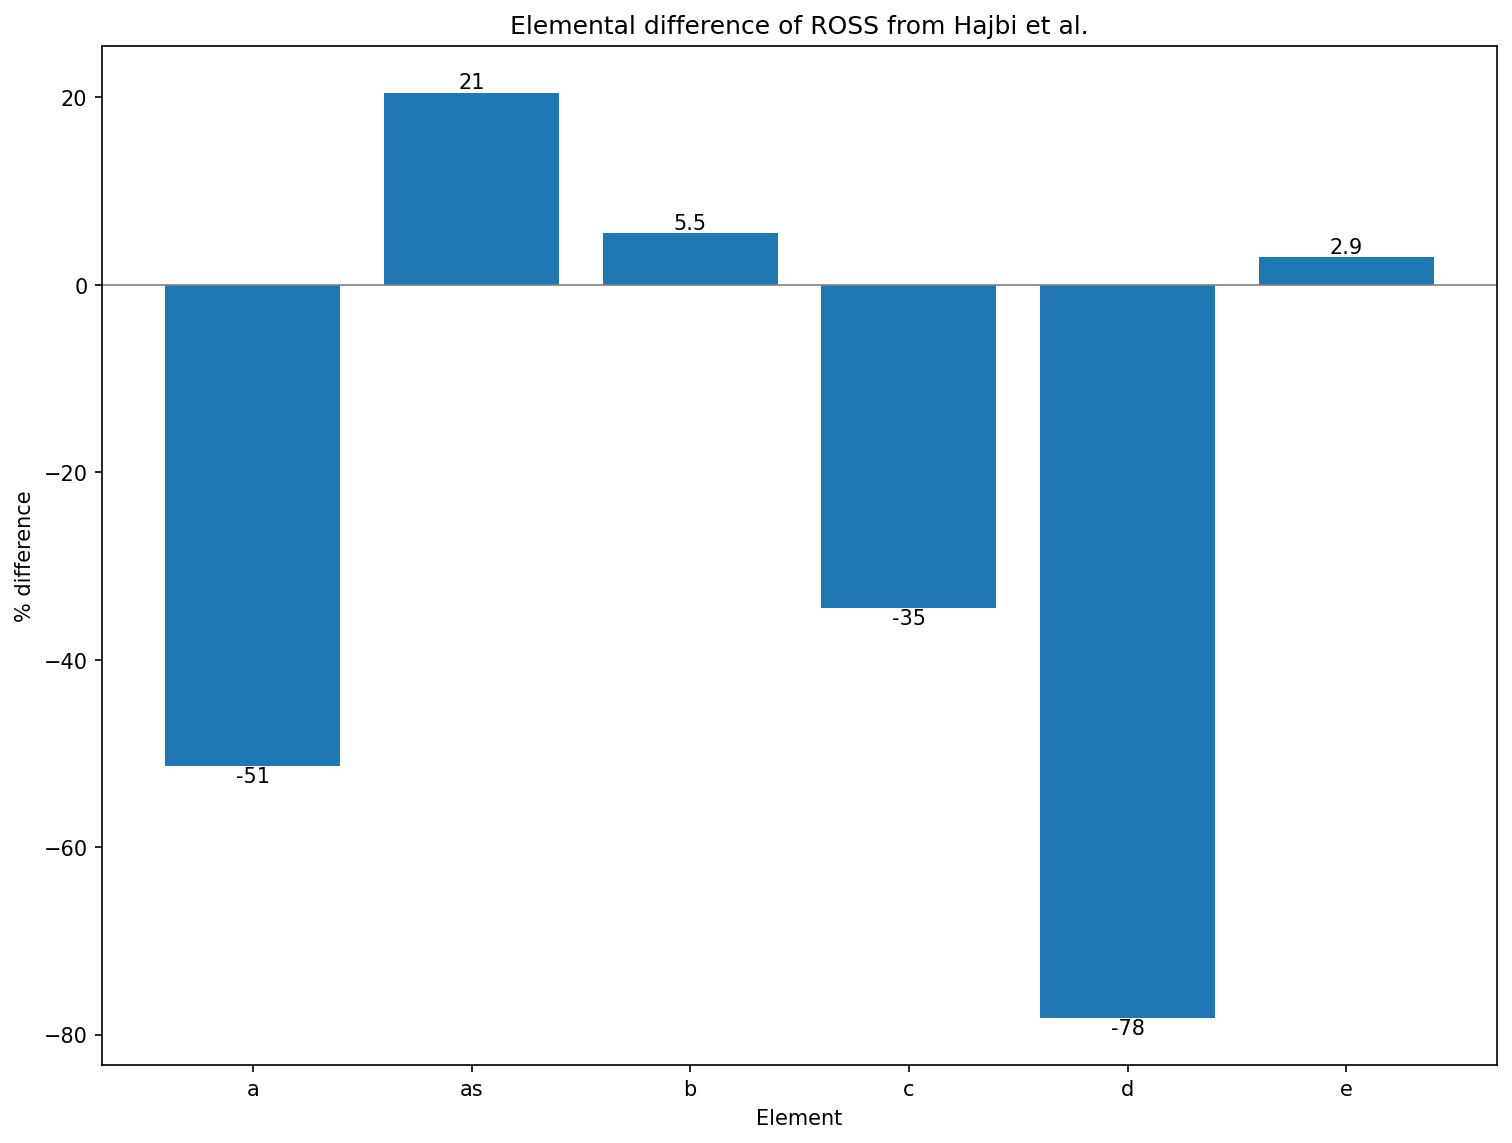

In [22]:
from matplotlib import pyplot 
from to_precision import auto_notation

diff_list = [-51.319690191159374, 20.51068337642654, 5.49589258808227, -34.51430755140045, -78.23347099033012, 2.9347998469192498]
labels = ['a', 'as', 'b', 'c', 'd', 'e']
min_diff = min(diff_list) - 5
max_diff = max(diff_list) + 5

pyplot.rcParams['figure.figsize'] = (12, 9)
figure, ax = pyplot.subplots()
bar_graph = ax.bar(labels, diff_list)
ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('% difference')
ax.set_ylim(min_diff, max_diff)
ax.set_xlabel('Element')
ax.set_title('Elemental difference of ROSS from Hajbi et al.')
diff_list = [auto_notation(value, 2) for value in diff_list]
ax.bar_label(bar_graph, diff_list)

In [49]:
import pandas
data = {'3':{
    'gypsum': 12,
    'barite': 4,
    },
       '5':{
    'gypsum': 22,
    'barite': 42,
    }
}
data2 = {'4':{
    'gypsum': 12,
    'barite': 42,
    },
       '6':{
    'gypsum': 23,
    'calcite': 42,
    }
}

data_df = pandas.DataFrame(data)
data_df2 = pandas.DataFrame(data2)
print(data_df)
print(data_df2)
scaling_data = data_df.merge(data_df2, how = 'outer', left_index = True, right_index = True) #, ignore_index = True)
scaling_data.sort_index(ascending = True, inplace = True)
print(scaling_data)

         3   5
gypsum  12  22
barite   4  42
            4     6
gypsum   12.0  23.0
barite   42.0   NaN
calcite   NaN  42.0
            3     5     4     6
barite    4.0  42.0  42.0   NaN
calcite   NaN   NaN   NaN  42.0
gypsum   12.0  22.0  12.0  23.0


In [34]:
df = pandas.DataFrame({'mass_H2O': [23,21,2321]})

print(df['mass_H2O'][0])

23


In [33]:
import pandas
data = {}
x = 0
while x < 5:
    data = {'3':{
        'gypsum': 12,
        'barite': 4,
        },
           '5':{
        'gypsum': 22,
        'barite': 42,
        }
   }
    if x == 0:
        print('1')
        scaling_data = pandas.DataFrame(data)
        x += 1
        continue
        
    data_df = pandas.DataFrame(data)
    print(data_df)
    scaling_data = scaling_data.append(data_df) #, ignore_index = True)
    print('2')
    x += 1
    
print(scaling_data)

1
         3   5
gypsum  12  22
barite   4  42
2
         3   5
gypsum  12  22
barite   4  42
2
         3   5
gypsum  12  22
barite   4  42
2
         3   5
gypsum  12  22
barite   4  42
2
         3   5
gypsum  12  22
barite   4  42
gypsum  12  22
barite   4  42
gypsum  12  22
barite   4  42
gypsum  12  22
barite   4  42
gypsum  12  22
barite   4  42


In [19]:
import datetime

time = datetime.datetime.now()
print(datetime.tzinfo.tzname(time))#.timezone)

TypeError: descriptor 'tzname' requires a 'datetime.tzinfo' object but received a 'datetime.datetime'